<a href="https://colab.research.google.com/github/stmoon/CS470/blob/master/CS470_Assignment_1_CNN_classification_with_Cifar10_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS470 Assignment #1: CNN classification with Cifar10
====

SungTae Moon (20185446)


## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on.



In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Step 2: Import modules

In [2]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


## Step 3: Configure the experiments

In [3]:
# training & optimization hyper-parameters
max_epoch = 200
learning_rate = 0.001
batch_size = 20000
device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://778b8cc9.ngrok.io


## Step 4: Construct data pipeline

**`torchvision.datasets.CIFAR10`** will automatically construct **`Cifar10`** dataset.

In [4]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Step 5: Construct a neural network builder


In [0]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F



class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()

        self.growth_rate = growth_rate
        self.reduction = reduction

        num_planes = 2*self.growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1, num_planes = self.dense_block(num_planes, 6)
        self.trans1, num_planes = self.transition(num_planes)

        self.dense2, num_planes = self.dense_block(num_planes, 12)
        self.trans2, num_planes = self.transition(num_planes)
        
        self.dense3, num_planes = self.dense_block(num_planes, 24)
        self.trans3, num_planes = self.transition(num_planes)

        self.dense4, num_planes = self.dense_block(num_planes, 16)

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def dense_block(self, in_planes, nblock) :
        layers = []
        for i in range(nblock):
            layers.append(Bottleneck(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers), in_planes

    def transition(self, in_planes) :
        out_planes = int(math.floor(in_planes*self.reduction))
        trans = Transition(in_planes, out_planes)
        return trans, out_planes
 
    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


## Step 6: Initialize the network and optimizer

If you want to train modularized neural network in Step 5B, please use 'MyClassifier2' as 'my_classifier'. It is written as a comment now.

In [26]:
from torchsummary import summary

device = 'cuda'
my_classifier = DenseNet()
my_classifier = my_classifier.to(device)

summary(my_classifier, (3, 32, 32))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
 

# Print your neural network structure
# print(my_classifier)
print('parameter size : ', count_parameters(my_classifier))

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,152
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
        Bottleneck-6           [-1, 36, 32, 32]               0
       BatchNorm2d-7           [-1, 36, 32, 32]              72
            Conv2d-8           [-1, 48, 32, 32]           1,728
       BatchNorm2d-9           [-1, 48, 32, 32]              96
           Conv2d-10           [-1, 12, 32, 32]           5,184
       Bottleneck-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 48, 32, 32]           2,304
      BatchNorm2d-14           [-1, 48,

## Step 7: Load pre-trained weights if exist

- **For your sumbmission you have to store the trained model as a checkpoint.**
- Please do not erase this step.
- If you want to modify this step, please be careful.
- After training please confirm that your checkpoint is correctly stored and re-loaded.

In [37]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

best_acc = 0.
# ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
ckpt_path = os.path.join(ckpt_dir, 'lastest_best_700epoch.pt')

print(ckpt_path)
if os.path.exists(ckpt_path):
  
  ckpt = torch.load(ckpt_path)
  try:
#     state_dict = ckpt['my_classifier']
#     state_dict_new = {k.partition('module.')[2]: v for k,v in state_dict.items()}    
#     my_classifier.load_state_dict(state_dict_new)
    
    my_classifier.load_state_dict(ckpt['my_classifier'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  
#     ckpt['my_classifier'] = state_dict_new
#     torch.save(ckpt, ckpt_path)
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

/gdrive/My Drive/checkpoints/lastest_best_700epoch.pt
checkpoint is loaded !
current best accuracy : 0.91


In [0]:
  !nvidia-smi

Mon Sep 23 09:56:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    69W / 149W |    342MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [0]:
training_process = True

if training_process:
  it = 0
  train_losses = []
  test_losses = []
  for epoch in range(max_epoch):
    # train phase
    my_classifier.train()
    for inputs, labels in train_dataloader:
      it += 1

      # load data to the GPU.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # feed data into the network and get outputs.
      logits = my_classifier(inputs)

      # calculate loss
      # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
      loss = F.cross_entropy(logits, labels)

      # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
      #       Otherwise, gradients will accumulate.
      optimizer.zero_grad()

      # backprogate loss.
      loss.backward()

      # update the weights in the network.
      optimizer.step()

      # calculate accuracy.
      acc = (logits.argmax(dim=1) == labels).float().mean()

      if it % 200 == 0:
        tbc.save_value('Loss', 'train_loss', it, loss.item())
        tbc.save_value('Accuracy', 'train_acc', it, acc.item())
        print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))

    # save losses in a list so that we can visualize them later.
    train_losses.append(loss)  

    # test phase
    n = 0.
    test_loss = 0.
    test_acc = 0.
    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)

      logits = my_classifier(test_inputs)
      test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
      test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
      n += test_inputs.size(0)

    test_loss /= n
    test_acc /= n
    test_losses.append(test_loss)
    tbc.save_value('Loss', 'test_loss', it, test_loss)
    tbc.save_value('Accuracy', 'test_acc', it, test_acc)
    print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss, test_acc)) 

    tbc.flush_line('train_loss')
    tbc.flush_line('test_loss')

    # save checkpoint whenever there is improvement in performance
    if test_acc > best_acc:
      best_acc = test_acc
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'my_classifier':my_classifier.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_acc':best_acc}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    
tbc.close()

## Step 9: Visualize and analyze the results

Test_loss : 0.6216, Test accuracy : 0.9122


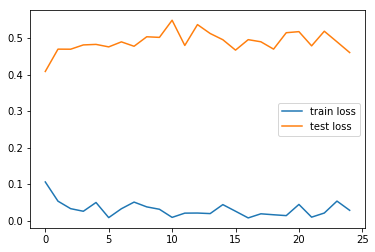

In [111]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

training_process = False

if not training_process:
  # Re-load trained model
  my_classifier.load_state_dict(ckpt['my_classifier'])
  optimizer.load_state_dict(ckpt['optimizer'])

  # Testing
  n = 0.
  test_loss = 0.
  test_acc = 0.
  my_classifier.eval()
  for test_inputs, test_labels in test_dataloader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    logits = my_classifier(test_inputs)
    test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
    test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
    n += test_inputs.size(0)

  test_loss /= n
  test_acc /= n
  print('Test_loss : {:.4f}, Test accuracy : {:.4f}'.format(test_loss, test_acc))

label : dog
prediction : cat


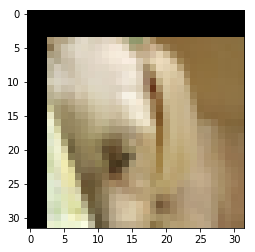

In [41]:
import random

import matplotlib.pyplot as plt
import numpy as np

my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)


test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

# <font color="blue"> Discussion and Analysis </font>

## Architecture

CIFAR10 에 대한 classification을 수행하기 위해, 본 과제에서는 DenseNet (Densely Connected Convolutional Networks)논문에 작성된 내용을 기반으로 개발 및 시험하였다.

논문에 나와있는 그림과 같이, DenseNet은 feature map 끼리 서로 densely하게 얽혀있는 구조로 되어있다. 그 결과, 기존 base model과 비교하여 Resnet과 같은 효과를 낼 수가 있었다. 뿐만 아니라, 전체적으로 더 많이 얽혀 있기 때문에 feature map을 좀더 잘 이해할 수 있을 것으로 판단된다. 뿐만 아니라, ResNet가 비교시 전체 채널 수가 growth rate만큼만 증가하기 때문에 전체 파라미터 갯수도 적다. 한편, ResNet과 비교시 feature map을 더해주는 방식이 아닌 추가하는 방식(concatenation)으로 운용된다

본 과제에서는 기본적으로 DenseNet 121을 따르고 있고, colab의 GPU 메모리 한계로 4개의 Dense Block을 사용했으며, 각 블럭의 bottleneck 개수는 6, 12, 24, 16을 사용했다. growth rate은 12개를 사용하였다. 

전체 네트워크 구조는 다음과 같다


In [42]:
from torchsummary import summary
summary(my_classifier, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,152
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
        Bottleneck-6           [-1, 36, 32, 32]               0
       BatchNorm2d-7           [-1, 36, 32, 32]              72
            Conv2d-8           [-1, 48, 32, 32]           1,728
       BatchNorm2d-9           [-1, 48, 32, 32]              96
           Conv2d-10           [-1, 12, 32, 32]           5,184
       Bottleneck-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 48, 32, 32]           2,304
      BatchNorm2d-14           [-1, 48,

## Experiments For Improvement

### Experiment For Improvement #1

기존 Base Model에서 성능 향상을 위해 Data Augmentation을 수행하였다. 기존에는 단순하게 정규화만 수행했는데, 여기에 Random Crop과 Random Horizontal Flip을 추가하였다.

- 기존 방식

```python
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
```

- 개선 방식

```python
transform = transforms.Compose([
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
```

수행 결과, Data Augumentation 수행 여부에 따라 많은 변화가 있었다.

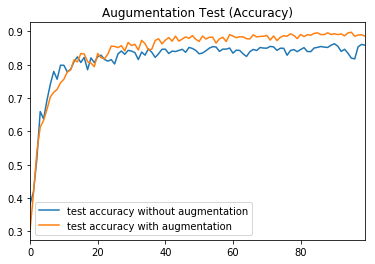

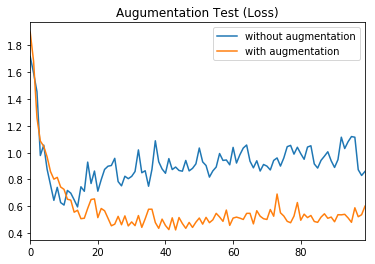

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ckpt_dir = os.path.join(gdrive_root, 'Colab Notebooks')

ckpt_path = os.path.join(ckpt_dir, 'witout_augment.csv')
df_before = pd.read_csv(ckpt_path)

ckpt_path = os.path.join(ckpt_dir, 'adaptive_lr_before.csv')
df_after = pd.read_csv(ckpt_path)

df_before['test_acc'].plot(label='test accuracy without augmentation')
df_after['test_acc'].plot(label='test accuracy with augmentation')

plt.title('Augumentation Test (Accuracy)')
plt.legend()
plt.show()

df_before['test_loss'].plot(label='without augmentation')
df_after['test_loss'].plot(label='with augmentation')

plt.title('Augumentation Test (Loss)')
plt.legend()
plt.show()


### Experiment For Improvement #2


다음은 learning rate을 조절하여 빠른 성능을 향상 시키는 부분에 대해 검토해보았다. 시험을 위해 100 epoch를 수행하였으며, learning rate을 0.1, 0.01. 0.001 로 30 epoch마다 다음과 같이 변경하도록 하였다.


```
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

scheduler.step()
```

수행 결과, 생각과 달리 개선 효과가 빨리 진행되지 않았으며, 전체적으로 변경하지 않았을때와 큰 차이가 없었다.




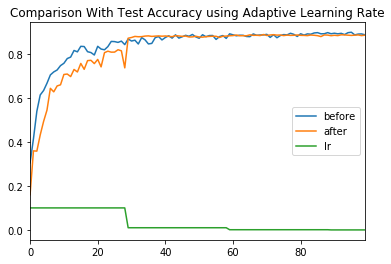

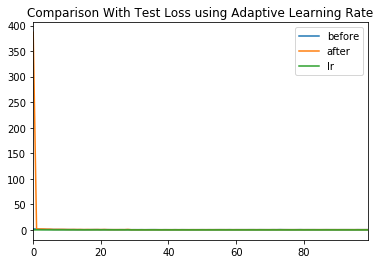

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ckpt_dir = os.path.join(gdrive_root, 'Colab Notebooks')

ckpt_path = os.path.join(ckpt_dir, 'adaptive_lr_before.csv')
df_before = pd.read_csv(ckpt_path)

ckpt_path = os.path.join(ckpt_dir, 'adaptive_lr_after2.csv')
df_after = pd.read_csv(ckpt_path)

df_before['test_acc'].plot(label='before')
df_after['test_acc'].plot(label='after')
df_after['lr'].plot(label='lr')

plt.title('Comparison With Test Accuracy using Adaptive Learning Rate')
plt.legend()
plt.show()

df_before['test_loss'].plot(label='before')
df_after['test_loss'].plot(label='after')
df_after['lr'].plot(label='lr')

plt.title('Comparison With Test Loss using Adaptive Learning Rate')
plt.legend()
plt.show()


## Result

학습은 총 700 Epoch를 수행했으며, 네트워크 모델은 DenseNet을 기반으로 개발하였다. 그 결과 전체 시스템 성능은 91.36%까지 개선되었으며, 100개 영상을 테스트로 수행해본 결과 아래와 같은 성능이 나왔다.

current accuracy for test :  0.913599967956543


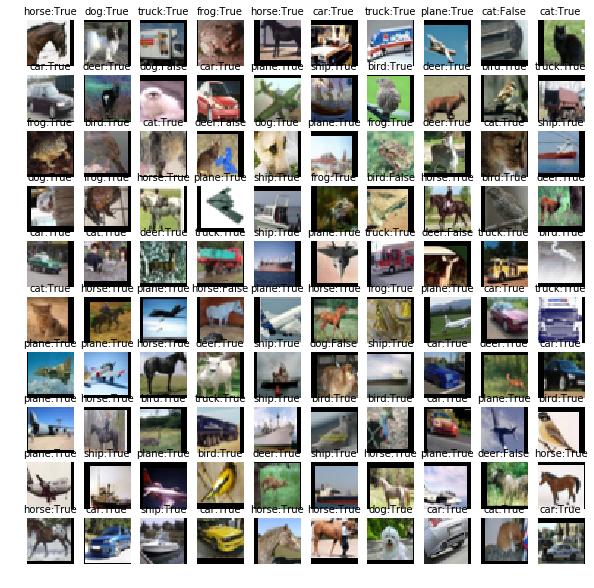

In [80]:
import random

import matplotlib.pyplot as plt
import numpy as np

my_classifier.eval()


print("current accuracy for test : ", ckpt['best_acc'].item())

num_test_samples = len(test_dataset)
fig=plt.figure(figsize=(10,10))
for i in range(10) :
  for j in range(10) :
    random_idx = random.randint(0, num_test_samples)
    test_input, test_label = test_dataset.__getitem__(random_idx)
    test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
    sub = fig.add_subplot(10, 10, 10*i+j+1)
    res = test_label == test_prediction
    sub.set_title(str(classes[test_label]) + ":" + str(res), fontsize=10)
    plt.axis('off')
    npimg = (test_input.numpy() + 1.0 ) / 2.0
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
  
plt.show()
